In [3]:

# Step 1: Upload and Extract LISA Traffic Light Dataset (Kaggle)
import zipfile
import os

zip_path = "lisa-traffic-light-dataset.zip"  # Ensure this is uploaded
extract_to = "lisa_dataset"

if not os.path.exists(extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
print("Dataset extracted.")


Dataset extracted.


In [15]:
import os
import pandas as pd
import shutil
from PIL import Image

# Step 1: Auto-merge all annotation CSV files
csv_files = []
for root, dirs, files in os.walk("lisa_dataset"):
    for file in files:
        if file.lower().endswith(".csv"):
            csv_files.append(os.path.join(root, file))

if not csv_files:
    raise FileNotFoundError("❌ No CSV annotation files found in 'lisa_dataset/'")

dataframes = []
for csv_file in csv_files:
    try:
        df = pd.read_csv(csv_file)
        df['source_file'] = os.path.basename(csv_file)  # Optional: track source
        dataframes.append(df)
    except Exception as e:
        print(f"⚠️ Skipped {csv_file}: {e}")

merged_df = pd.concat(dataframes, ignore_index=True)
os.makedirs("lisa_dataset", exist_ok=True)
merged_csv_path = os.path.join("lisa_dataset", "annotations_combined.csv")
merged_df.to_csv(merged_csv_path, index=False)
print(f"✅ Merged {len(csv_files)} CSV files into '{merged_csv_path}'")

# Step 2: Load merged annotations
df = pd.read_csv(merged_csv_path)

# Step 3: Auto-detect the image path column
filename_column = next((col for col in df.columns if 'file' in col.lower() or 'frame' in col.lower()), None)
if not filename_column:
    raise ValueError("❌ Could not find a filename column (like 'Filename' or 'Frame')")

# Step 4: Ensure YOLO directories exist
os.makedirs("data/images", exist_ok=True)
os.makedirs("data/labels", exist_ok=True)

# Step 5: Convert annotations to YOLO format
for idx, row in df.iterrows():
    try:
        image_rel_path = str(row[filename_column]).replace("\\", "/")
        image_path = os.path.join("lisa_dataset", image_rel_path)

        if not os.path.exists(image_path):
            continue

        # Copy image
        dest_img_path = os.path.join("data/images", os.path.basename(image_path))
        shutil.copy(image_path, dest_img_path)

        # Get size using PIL
        with Image.open(image_path) as img:
            img_width, img_height = img.size

        # Read bounding box coordinates
        x1 = float(row['Upper left corner X'])
        y1 = float(row['Upper left corner Y'])
        x2 = float(row['Lower right corner X'])
        y2 = float(row['Lower right corner Y'])

        # YOLO conversion
        w = x2 - x1
        h = y2 - y1
        cx = x1 + w / 2
        cy = y1 + h / 2

        cx /= img_width
        cy /= img_height
        w /= img_width
        h /= img_height

        # Write YOLO label
        label_file = os.path.splitext(os.path.basename(image_path))[0] + ".txt"
        label_path = os.path.join("data/labels", label_file)
        with open(label_path, "a") as f:
            f.write(f"0 {cx:.6f} {cy:.6f} {w:.6f} {h:.6f}\n")  # Class 0 = traffic light

    except Exception as e:
        print(f"⚠️ Error at row {idx}: {e}")
        continue

print("✅ YOLO annotations successfully created.")


✅ Merged 48 CSV files into 'lisa_dataset\annotations_combined.csv'
✅ YOLO annotations successfully created.


In [17]:

# Step 3: Prepare YOLOv5 Dataset YAML
with open("lisa.yaml", "w") as f:
    f.write("""path: data
train: images
val: images

names:
  0: traffic_light
""")

print("YOLOv5 dataset YAML created.")


YOLOv5 dataset YAML created.


In [21]:
# Clone YOLOv5 from GitHub
!git clone https://github.com/ultralytics/yolov5


Cloning into 'yolov5'...


In [23]:
# Change directory to yolov5 (use %cd in Jupyter)
%cd yolov5


C:\Users\Asus\Documents\Github\Traffic-Light-Detection\model_training\yolov5


In [25]:
# Install requirements for YOLOv5
!pip install -r requirements.txt


In [27]:
!pip install torch

In [29]:
!pip install --user opencv-python

In [31]:
!ls ../dataset
!cat ../dataset/data.yaml


'ls' is not recognized as an internal or external command,
operable program or batch file.
'cat' is not recognized as an internal or external command,
operable program or batch file.


In [39]:
!python train.py --img 416 --batch 16 --epochs 30 --data ../dataset/data.yaml --weights yolov5s.pt --name traffic_light_model


train: weights=yolov5s.pt, cfg=, data=../lisa.yaml, hyp=data\hyps\hyp.scratch-low.yaml, epochs=30, batch_size=16, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data\hyps, resume_evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs\train, name=traffic_light_model, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest, ndjson_console=False, ndjson_file=False
github: up to date with https://github.com/ultralytics/yolov5 
YOLOv5  v7.0-419-gcd44191c Python-3.12.3 torch-2.7.0+cpu CPU

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=

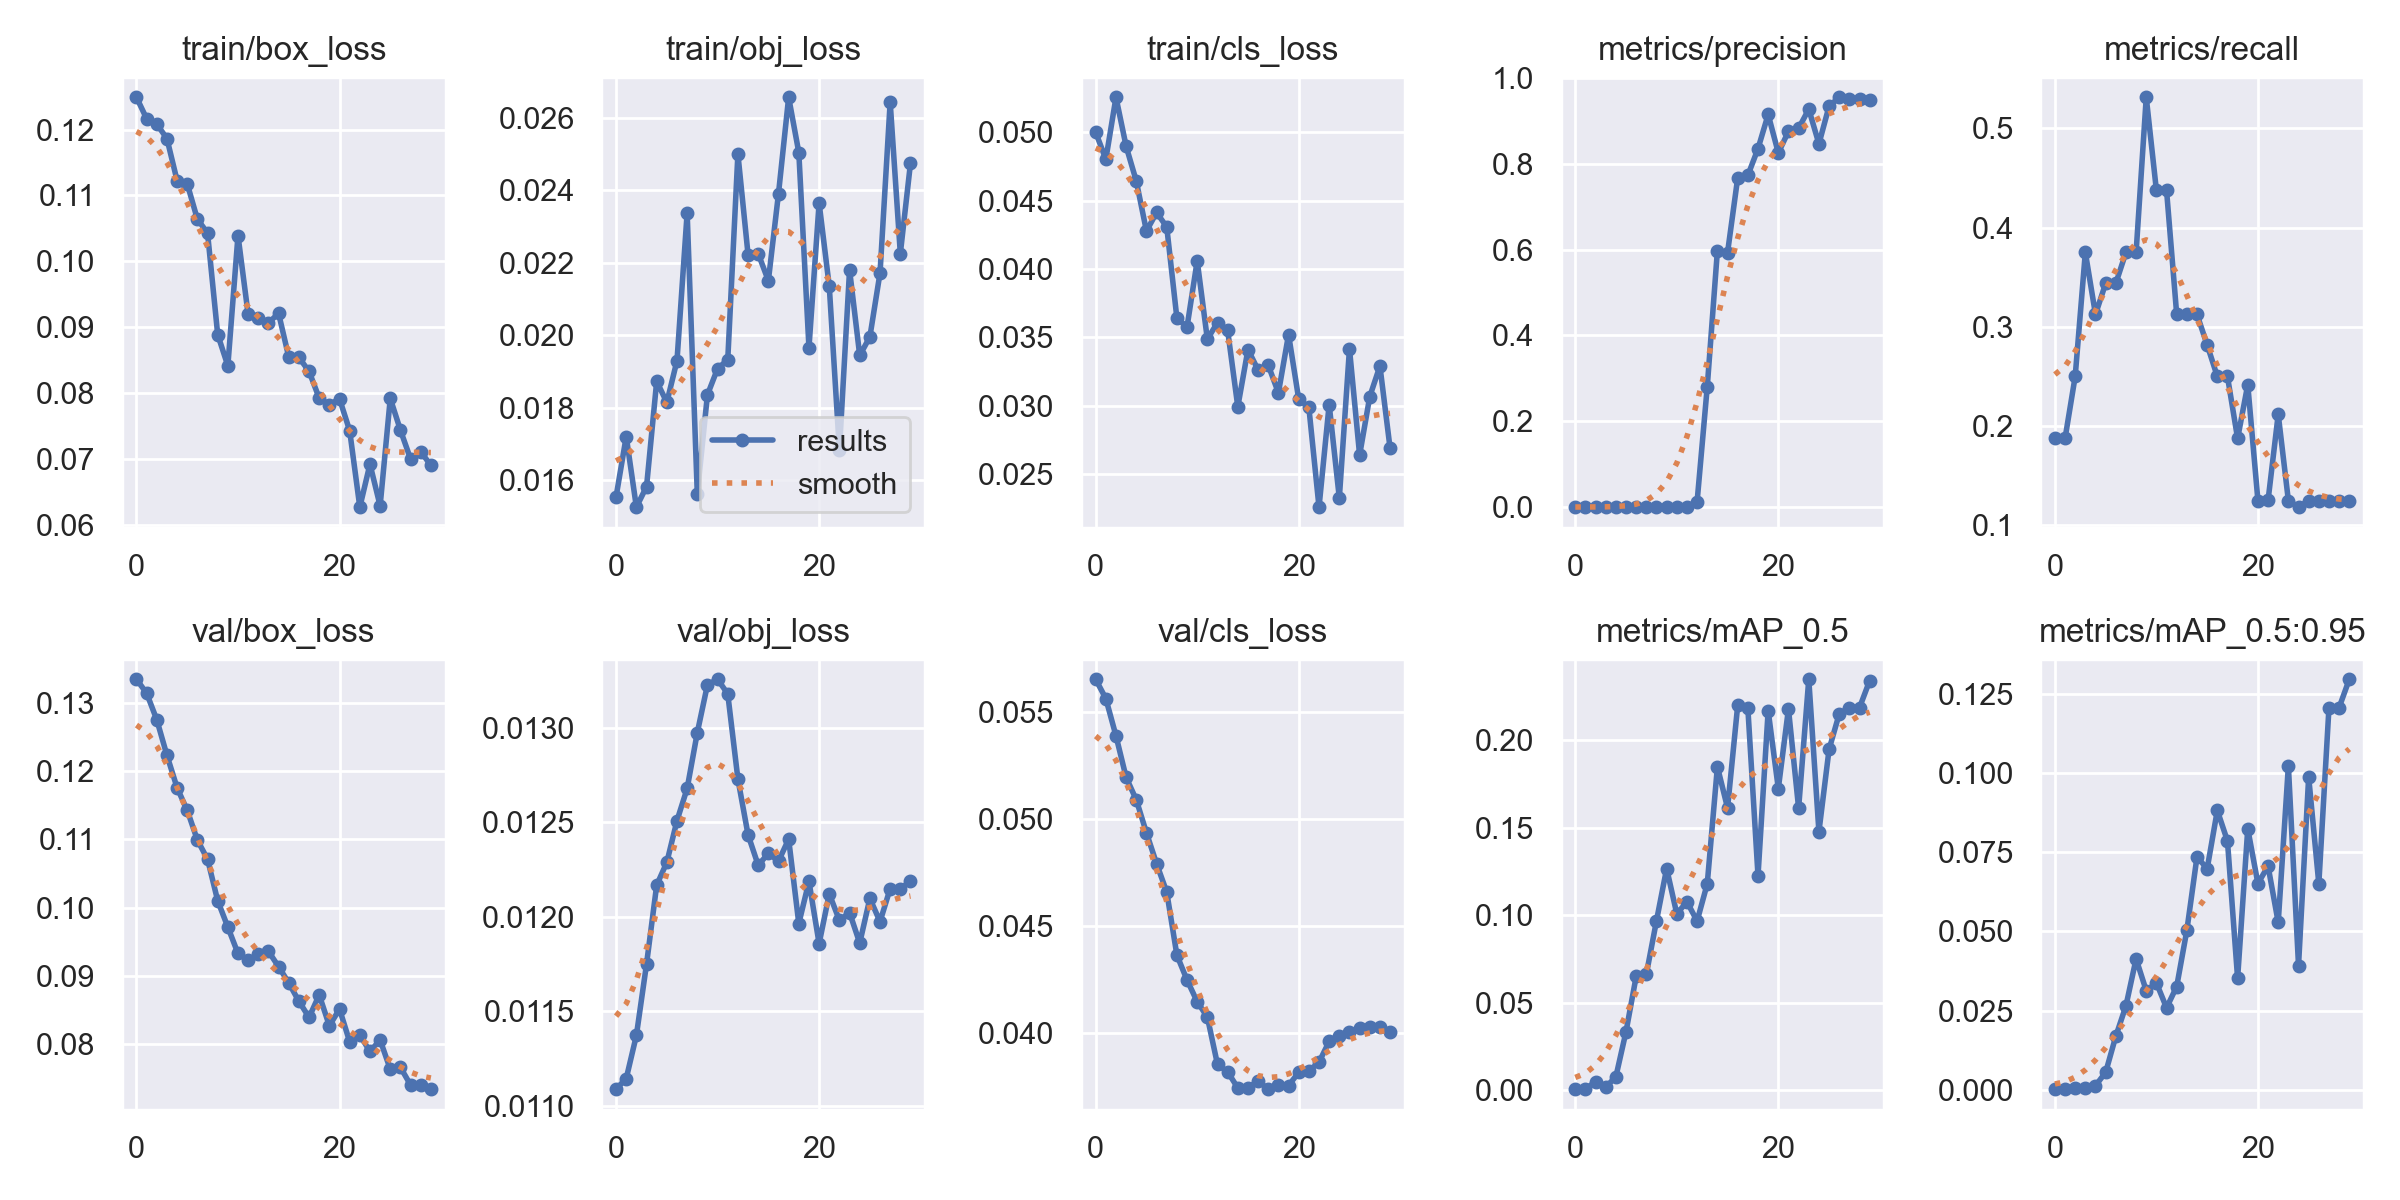

In [13]:
from IPython.display import Image
Image(filename='runs/train/traffic_light_model3/results.png', width=600)
